# Check drift on Equivitals and compensate for missing cues 
Evaluate how the equivital sensors clocks drift and calculate how best to compensate for missing synchronisation cues. 

In [2]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [3]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

In [4]:
%reload_ext autoreload

In [5]:
out_dir = './outfiles/'
file_list = os.listdir(out_dir)
file_list 

['20240307EQIVITALS_CUTLOGS.csv',
 'Cue_dev_align_20240308.csv',
 'Cue_dev_align_20240309.csv',
 'cue1_20240304.csv',
 'cue1_20240305.csv',
 'cue2_acc_20240304.csv',
 'cue1_20240307.csv',
 'cue2_20240309.csv',
 'cue2_20240308.csv',
 'cue1_acc_20240306.csv',
 'cue2_20240305.csv',
 'cue2_20240307.csv',
 'cue1_acc_20240304.csv',
 'cue3_20240305.csv',
 'cue1_20240308.csv',
 'cue1_20240309.csv',
 'Cue_dev_align_20240307.csv',
 'Cue_ACC_dev_align_20240306.csv',
 'Cue_ACC_dev_align_20240304.csv',
 'Cue_dev_align_20240305.csv']

Collect the cue and clock information for the four of six days when two cues were recording with an external audio clock anchor. 

Synchronisation cue timing has been assessed in the AccSynchFinder paper and saved in CSV files of the form: 'Cue_dev_align_20240307.csv'. These contain the device timestamps of accelerometer-imbedded synchronisations cues that were produced in all equivital devices using a shaker table before and after recording intervals. 

Two of the recording days had missing or incomplete sychronisation cues, and here estimates of device clock properties are used to compensate.

Gather the two synch measurements per day. dev_C is the time scaling constant to convert device timestamps into audio time. drift_s and drift_rate_spher reports the drift captured after a full recording or over a second.

In [29]:
cols = ['DevName', 'Cue1_devdTime', 'Cue1_s', 'Cue1_r', 'Cue2_devdTime',
       'Cue2_s', 'Cue2_r', 'dur_dt', 'dur_s', 'devID', 'drift_s',
       'drift_rate_sphr', 'ACCFile', 'Cue1_file', 'Cue1_name', 'Cue1_dt',
       'Cue2_file', 'Cue2_name', 'Cue2_dt','dev_C','Day']
All_sync = pd.DataFrame(columns = cols)
for f in file_list:
    if f.startswith('Cue_dev'):
        A = pd.read_csv(out_dir+f)
        A['dev_C'] = (pd.to_datetime(A['Cue2_dt']) - pd.to_datetime(A['Cue1_dt'])).dt.total_seconds()/(pd.to_datetime(A['Cue2_devdTime']) - pd.to_datetime(A['Cue1_devdTime'])).dt.total_seconds()
        A['Day']=f[18:22]
        mid_cols = list(set(cols).intersection(set(A.columns)))
        All_sync = pd.concat([All_sync,A.loc[:,mid_cols]],axis=0)
All_sync.reset_index(inplace = True, drop = True)
All_sync

<ipython-input-29-e008e636226c>:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  All_sync = pd.concat([All_sync,A.loc[:,mid_cols]],axis=0)


,DevName,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,...,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt,dev_C,Day
0,AU808,2024-03-08 06:49:58.098053075,-2.472656,0.607847,2024-03-08 14:04:37.947703075,-0.691406,0.588710,0 days 07:14:39.849650,26079.849650,5022031,...,-0.245861,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,1.000068,0308
1,AU807,2024-03-08 06:49:56.320709325,-0.695312,0.517968,2024-03-08 14:04:35.893015575,1.363281,0.661651,0 days 07:14:39.572306250,26079.572306,5022058,...,-0.284143,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,1.000079,0308
2,AU806,2024-03-08 06:49:58.402740575,-2.777344,0.583299,2024-03-08 14:04:38.213328075,-0.957031,0.573120,0 days 07:14:39.810587500,26079.810588,5022155,...,-0.251253,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,1.000070,0308
3,AU805,2024-03-08 06:49:57.039459325,-1.414062,0.626559,2024-03-08 14:04:36.795359325,0.460938,0.651299,0 days 07:14:39.755900,26079.755900,5022002,...,-0.258802,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,1.000072,0308
4,AU804,2024-03-08 06:49:56.953521825,-1.328125,0.608979,2024-03-08 14:04:36.549265575,0.707031,0.733450,0 days 07:14:39.595743750,26079.595744,5022184,...,-0.280908,/Volumes/Seagatehub/BiC2024/20240308/Equivital...,./outfiles/cue1_20240308.csv,cue1_20240308,2024-03-08 06:49:52.625396825,./outfiles/cue2_20240308.csv,cue2_20240308,2024-03-08 14:04:34.256287982,1.000078,0308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,BR609,2024-03-05 07:42:23.241221655,-0.968750,0.503853,2024-03-05 13:52:59.249796655,0.609375,0.732130,0 days 06:10:36.008575,22236.008575,5022222,...,-0.255478,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,1.000071,0305
140,PC702,2024-03-05 07:42:22.198252905,0.074219,0.419131,2024-03-05 13:52:58.292765405,1.566406,0.753346,0 days 06:10:36.094512500,22236.094512,5022240,...,-0.241566,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,1.000067,0305
141,PC710,2024-03-05 07:42:22.022471655,0.250000,0.453164,2024-03-05 13:52:57.976359155,1.882812,0.713439,0 days 06:10:35.953887500,22235.953887,5022204,...,-0.264331,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,1.000073,0305
142,PC709,2024-03-05 07:42:22.932627905,-0.660156,0.351801,2024-03-05 13:52:59.046671655,0.812500,0.614218,0 days 06:10:36.114043750,22236.114044,5022299,...,-0.238404,/Volumes/Seagatehub/BiC2024/20240305/Equivital...,./outfiles/cue1_20240305.csv,cue1_20240305,2024-03-05 07:42:22.272471655,./outfiles/cue2_20240305.csv,cue2_20240305,2024-03-05 13:52:59.859163265,1.000066,0305


/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


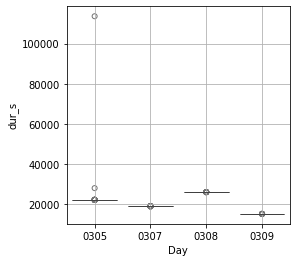

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


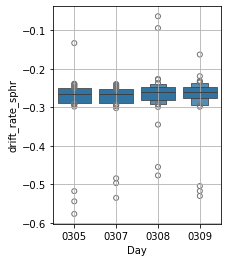

In [43]:
tag_Q = 'Day'
tag_m = 'dur_s'
f, (ax1) = plt.subplots(1, 1,figsize=(4,4))
sns.boxenplot(x = 'Day',y = tag_m, data =All_sync, ax = ax1,order = ['0305','0307','0308','0309'])
plt.grid()
plt.show()
tag_m = 'drift_rate_sphr' #'Scaling_C' # Cue1_shift
f, (ax1) = plt.subplots(1, 1,figsize=(3,4))
#response_order = ['Hall','Virtual']
sns.boxenplot(x = 'Day',y = tag_m,data = All_sync, ax = ax1,order = ['0305','0307','0308','0309'])
plt.grid()
plt.show()

The four days do not not differ significantly in implied drift rate, which is good as they over different in time intervals, from 3 hours to 8 hrs (with one extra long recording by accident.) 

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
<ipython-input-45-135145eac1e8>:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45,ha='right')#plt.set_xticklabels(rotation=45)


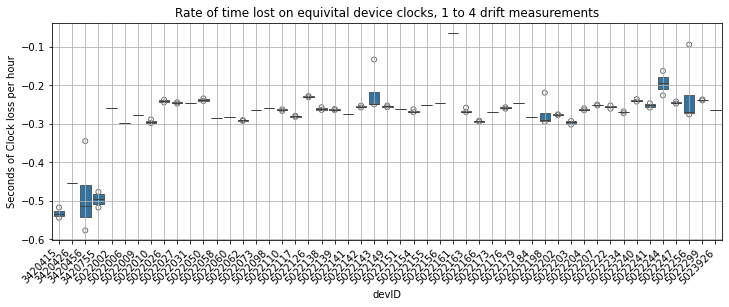

In [45]:
tag_m = 'drift_rate_sphr' #'Scaling_C' # Cue1_shift
f, (ax1) = plt.subplots(1, 1,figsize=(12,4))
sns.boxenplot(x = 'devID',y =tag_m,data = All_sync, ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(),rotation=45,ha='right')#plt.set_xticklabels(rotation=45)
ax1.set_ylabel('Seconds of Clock loss per hour')
plt.title('Rate of time lost on equivital device clocks, 1 to 4 drift measurements')
plt.grid()
plt.savefig('./plots/TimeScaling_Equivitals.png',bbox_inches = 'tight',dpi = 300)
plt.show()

The amount of hourly clock drift measured per device seems to be pretty consistent across repeated measurements. The rates are specific to the SEM, so we can use to estimates from other measurements to fill in missing data. On average, the devices lose 257 ms per hour, but it ranges from 200 ms and 550 ms. 

As with last year, the devices with earlier serial numbers have greater drift, however the inconsistency is much more contained than when also adding variance in human reaction time (tap sync instead of table sync).

I checked those cases where the device drift differed over measurements, in case it was an alignemnt error with the shaker sync cue detection. There was no noticeable error in the alignements (see notebooks for plots) so it seems some variability in clock drift per devices, though the factors are not obvious. Maybe related to battery life, but who knows. 

AS a safeguared, device-wise drift is probably best modelled from the median rather than the mean across measurements, assuming the predominant conditions are kind of stable.

In [46]:
Mean_Drifts = pd.DataFrame(index = All_sync['DevName'].unique(),columns = ['devID','mean_drift','median_drift','std_drift'])
for dev in All_sync['DevName'].unique():
    B = All_sync.query('DevName==@dev')
    sName =  dev
    devID = B.loc[:,'devID'].iloc[0]
    print(B.loc[:,['DevName','Day','drift_rate_sphr','dev_C']])
    print([sName,B.loc[:,'drift_rate_sphr'].mean(),B.loc[:,'drift_rate_sphr'].median()])
    Mean_Drifts.loc[sName,'devID']=devID
    Mean_Drifts.loc[sName,'mean_drift',]=B.loc[:,'drift_rate_sphr'].mean()
    Mean_Drifts.loc[sName,'median_drift']=B.loc[:,'drift_rate_sphr'].median()
    Mean_Drifts.loc[sName,'std_drift']=B.loc[:,'drift_rate_sphr'].std()
    Mean_Drifts.loc[sName,'mean_C',]=B.loc[:,'dev_C'].mean()
    Mean_Drifts.loc[sName,'median_C']=B.loc[:,'dev_C'].median()
    Mean_Drifts.loc[sName,'std_C']=B.loc[:,'dev_C'].std()
Mean_Drifts

  DevName   Day  drift_rate_sphr     dev_C
0   AU808  0308        -0.245861  1.000068
['AU808', -0.2458614504131672, -0.2458614504131672]
  DevName   Day  drift_rate_sphr     dev_C
1   AU807  0308        -0.284143  1.000079
['AU807', -0.2841427029994283, -0.2841427029994283]
  DevName   Day  drift_rate_sphr    dev_C
2   AU806  0308        -0.251253  1.00007
['AU806', -0.251253176129542, -0.251253176129542]
  DevName   Day  drift_rate_sphr     dev_C
3   AU805  0308        -0.258802  1.000072
['AU805', -0.2588015921324668, -0.2588015921324668]
  DevName   Day  drift_rate_sphr     dev_C
4   AU804  0308        -0.280908  1.000078
['AU804', -0.2809076675696034, -0.2809076675696034]
  DevName   Day  drift_rate_sphr     dev_C
5   AU801  0308        -0.246401  1.000068
['AU801', -0.2464006229848047, -0.2464006229848047]
  DevName   Day  drift_rate_sphr     dev_C
6   AU809  0308        -0.281986  1.000078
['AU809', -0.2819860127128784, -0.2819860127128784]
  DevName   Day  drift_rate_sphr     d

   DevName   Day  drift_rate_sphr     dev_C
50   AU817  0309         -0.26497  1.000074
['AU817', -0.2649698794355491, -0.2649698794355491]
    DevName   Day  drift_rate_sphr     dev_C
133   LS402  0305        -0.262434  1.000073
['LS402', -0.2624342821500516, -0.2624342821500516]


,devID,mean_drift,median_drift,std_drift,mean_C,median_C,std_C
AU808,5022031,-0.245861,-0.245861,NaN,1.000068,1.000068,NaN
AU807,5022058,-0.284143,-0.284143,NaN,1.000079,1.000079,NaN
AU806,5022155,-0.251253,-0.251253,NaN,1.000070,1.000070,NaN
AU805,5022002,-0.258802,-0.258802,NaN,1.000072,1.000072,NaN
AU804,5022184,-0.280908,-0.280908,NaN,1.000078,1.000078,NaN
AU801,5022179,-0.246401,-0.246401,NaN,1.000068,1.000068,NaN
AU809,5022060,-0.281986,-0.281986,NaN,1.000078,1.000078,NaN
AU810,5022098,-0.258262,-0.258262,NaN,1.000072,1.000072,NaN
AU811,5022173,-0.269585,-0.269585,NaN,1.000075,1.000075,NaN
AU813,5022244,-0.194199,-0.194199,0.044849,1.000054,1.000054,1.245942e-05


In [47]:
Mean_Drifts
for f in file_list:
    if f.startswith('Cue_dev'):
        A = pd.read_csv(out_dir+f,index_col = 0)
        A['dev_C'] = (pd.to_datetime(A['Cue2_dt']) - pd.to_datetime(A['Cue1_dt'])).dt.total_seconds()/(pd.to_datetime(A['Cue2_devdTime']) - pd.to_datetime(A['Cue1_devdTime'])).dt.total_seconds()
        Mean_Drifts[f[14:22]+'_C'] = A['dev_C']
        Mean_Drifts[f[14:22]+'_drift'] = A['drift_rate_sphr']
Mean_Drifts

,devID,mean_drift,median_drift,std_drift,mean_C,median_C,std_C,20240308_C,20240308_drift,20240309_C,20240309_drift,20240307_C,20240307_drift,20240305_C,20240305_drift
AU808,5022031,-0.245861,-0.245861,NaN,1.000068,1.000068,NaN,1.000068,-0.245861,NaN,NaN,NaN,NaN,NaN,NaN
AU807,5022058,-0.284143,-0.284143,NaN,1.000079,1.000079,NaN,1.000079,-0.284143,NaN,NaN,NaN,NaN,NaN,NaN
AU806,5022155,-0.251253,-0.251253,NaN,1.000070,1.000070,NaN,1.000070,-0.251253,NaN,NaN,NaN,NaN,NaN,NaN
AU805,5022002,-0.258802,-0.258802,NaN,1.000072,1.000072,NaN,1.000072,-0.258802,NaN,NaN,NaN,NaN,NaN,NaN
AU804,5022184,-0.280908,-0.280908,NaN,1.000078,1.000078,NaN,1.000078,-0.280908,NaN,NaN,NaN,NaN,NaN,NaN
AU801,5022179,-0.246401,-0.246401,NaN,1.000068,1.000068,NaN,1.000068,-0.246401,NaN,NaN,NaN,NaN,NaN,NaN
AU809,5022060,-0.281986,-0.281986,NaN,1.000078,1.000078,NaN,1.000078,-0.281986,NaN,NaN,NaN,NaN,NaN,NaN
AU810,5022098,-0.258262,-0.258262,NaN,1.000072,1.000072,NaN,1.000072,-0.258262,NaN,NaN,NaN,NaN,NaN,NaN
AU811,5022173,-0.269585,-0.269585,NaN,1.000075,1.000075,NaN,1.000075,-0.269585,NaN,NaN,NaN,NaN,NaN,NaN
AU813,5022244,-0.194199,-0.194199,0.044849,1.000054,1.000054,1.245942e-05,1.000063,-0.225912,1.000045,-0.162486,NaN,NaN,NaN,NaN


In [48]:
Mean_Drifts.to_csv(out_dir+'dev_drift.csv')

In [25]:
[Mean_Drifts['mean_drift'].mean(),Mean_Drifts['mean_drift'].std()]

[-0.2741603452189515, 0.07242238787592002]

## compensating within these days
there was one measurement that spanned two days, VN104, devN 3420456, that maybe needs to be handled differently for the first day, 0304, than the second 0305.

# Fixing 0304
on the first day of recording, these were just test measurements, but we can practice the correction process. Here the audio recording stopped before capturing the second synchronisation cue. While both synch cues have been evaluated on these sensors, we can test the median or mean drift rate to 

    1. Deterime the real amount of time between first and second cues (device time between cues * dev C)
    2. Check sync 2 alignment after correction 

In [89]:
A = pd.read_csv(out_dir+'Cue_ACC_dev_align_20240304.csv',index_col=0)
# A.loc[A['devID'] in Mean_Drifts['devID'],:]
A

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
SUBJECT ID,,,,,,,,,,,,,,,,,,
BLUETOOTH01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022281,NaN,NaN,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
BLUETOOTH04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022297,NaN,NaN,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
BLUETOOTH03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5022292,NaN,NaN,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN101,2024-03-04 07:56:25.407331250,-1.644531,0.489273,2024-03-04 14:25:43.633925,0.109375,0.682468,0 days 06:29:18.226593750,23358.226594,3420415,-3.210606,-0.494755,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
VN102,2024-03-04 07:56:25.383893750,-1.621094,0.495585,2024-03-04 14:25:44.051893750,-0.308594,0.707907,0 days 06:29:18.668000,23358.668000,3420426,-2.769200,-0.426734,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PC702,2024-03-04 07:56:26.055768750,-1.292969,0.555586,2024-03-04 14:25:47.071425,-2.328125,0.749781,0 days 06:29:21.015656250,23361.015656,5022240,-0.421544,-0.064960,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC703,2024-03-04 07:56:25.282331250,-1.519531,0.576534,2024-03-04 14:25:45.321425,-1.578125,0.802204,0 days 06:29:20.039093750,23360.039094,5022241,-1.398106,-0.215448,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200
PC704,2024-03-04 07:56:25.790143750,-2.027344,0.575410,2024-03-04 14:25:45.973768750,-2.230469,0.802896,0 days 06:29:20.183625,23360.183625,5022244,-1.253575,-0.193176,/Volumes/Seagatehub/BiC2024/20240304/Equivital...,./outfiles/cue1_acc_20240304.csv,cue1_20240304,2024-03-04 07:56:23.762800,./outfiles/cue2_acc_20240304.csv,cue2_20240304,2024-03-04 14:25:45.200


In [90]:
mid_devs= list(set(A['devID']).intersection(Mean_Drifts['devID']))
subA = A.query('devID in @mid_devs').copy()
len(subA)

50

In [93]:
subA['median_C'] = Mean_Drifts['median_C']

In [94]:
print([subA['dur_s'].mean(),subA['dur_s'].std()])

[23359.866437500004, 0.4740703068653457]


In [95]:
print([(subA['dur_s']*subA['median_C']).mean(),(subA['dur_s']*subA['median_C']).std()])

[23361.70180742632, 0.1802291403702323]


In [4]:
(23361.70- 6*3600)-29*60

21.700000000000728

Using estimated drift constants from other measurements produces less variation in the duration of measurement than the original device clock times. However, the difference isn't perfect. Standard deviation of 180 ms for cue alignment that is supposed to be down to 4 ms. 

However this result does give a more convincing likely time for the second alignment cue: 23361.7018s after cue1, roughly 2 seconds later than the device times average.

In [96]:
subA['Cue2_dt'] = pd.to_datetime(subA['Cue1_dt']) + pd.to_timedelta(23361.7018,unit='s')
subA['Cue2_dt_prelim'] = pd.to_datetime(subA['Cue1_dt']) + pd.to_timedelta(23359.8664,unit='s')

In [97]:
subA.to_csv(out_dir+'Cue_ACC_ReSynched_dev_align_20240304.csv')

In [98]:
Cue2_dt = pd.DataFrame()
Cue2_dt['withC'] = pd.to_datetime(subA['Cue1_dt']) + pd.to_timedelta(subA['dur_s']*subA['median_C'],unit='s')
Cue2_dt['withoutC']= pd.to_datetime(subA['Cue1_dt']) + pd.to_timedelta(subA['dur_s'],unit='s')
Cue2_dt['Off_uC'] = (Cue2_dt['withoutC']  - subA['Cue2_dt_prelim']).dt.total_seconds()
Cue2_dt['Off_C'] = (Cue2_dt['withC']  - subA['Cue2_dt']).dt.total_seconds()
Cue2_dt

,withC,withoutC,Off_uC,Off_C
SUBJECT ID,,,,
VN101,2024-03-04 14:25:45.460602594,2024-03-04 14:25:41.989393750,-1.639806,-0.003997
VN102,NaT,2024-03-04 14:25:42.430800000,-1.198400,NaN
VN106,NaT,2024-03-04 14:25:43.758925000,0.129725,NaN
VN105,2024-03-04 14:25:45.578285136,2024-03-04 14:25:42.372206250,-1.256994,0.113685
VN107,NaT,2024-03-04 14:25:43.516737500,-0.112463,NaN
VN108,NaT,2024-03-04 14:25:43.653456250,0.024256,NaN
VN204,NaT,2024-03-04 14:25:43.587050000,-0.042150,NaN
VN205,NaT,2024-03-04 14:25:43.598768750,-0.030431,NaN
VN207,NaT,2024-03-04 14:25:43.735487500,0.106287,NaN


In [99]:
Cue2_dt[['Off_uC','Off_C']].abs().mean()

Off_uC    0.256956
Off_C     0.070335
dtype: float64

In [100]:
Cue2_dt[['Off_uC','Off_C']].std()

Off_uC    0.474070
Off_C     0.180229
dtype: float64

These results suggest that while the alignment via estimated drift is helpful, it isn't perfect, with substantial variation in clock times still overriding perfect alignment. 

For 0304, this rehearsal day, it is better to use both cues and the estimated second cue time to reach maximal alignment across all sensors, especially since many weren't recording all days. (though most of these don't need to be saved as they caught no signals at this time. 

For 0306, it will be a bit more complicated

In [105]:
print([(pd.to_datetime(A['Cue1_dt']) - pd.to_datetime(A['Cue1_devdTime'])).dt.total_seconds().mean(),(pd.to_datetime(A['Cue1_dt']) - pd.to_datetime(A['Cue1_devdTime'])).dt.total_seconds().std()])
# initial alignment error

[-2.0691344246031744, 0.6088851628144306]


# now for 0306

This day has only one synch cue in the measurements, so will need to depende on estimated drift rates. 

If another potential synch cue comes up in the signals, that's great, but that's not likely 

In [110]:
A = pd.read_csv(out_dir+'Cue_ACC_dev_align_20240306.csv',index_col=0)
# A.loc[A['devID'] in Mean_Drifts['devID'],:]

A['median_C'] = Mean_Drifts['median_C']
A['Cue1_dt'] = pd.to_datetime('2024-03-06 07:12:07.671875').tz_localize(None) 

A.to_csv(out_dir+'Cue_ACC_ReSynched_dev_align_20240306.csv')
A

,Cue1_devdTime,Cue1_s,Cue1_r,devID,median_C,Cue1_dt
DevName,,,,,,
VN101,2024-03-06 07:12:07.890625,1.109375,0.566995,3420415,1.000149,2024-03-06 07:12:07.671875
VN104,2024-03-06 07:12:08.398437500,0.601562,0.453916,3420456,1.000143,2024-03-06 07:12:07.671875
VN105,2024-03-06 07:12:07.121093750,1.878906,0.450958,3420755,1.000137,2024-03-06 07:12:07.671875
VN109,2024-03-06 07:12:07.328125,1.671875,0.469074,5022010,1.000082,2024-03-06 07:12:07.671875
VN110,2024-03-06 07:12:08.507812500,0.492188,0.469037,5022026,1.000067,2024-03-06 07:12:07.671875
VN111,2024-03-06 07:12:07.046875,1.953125,0.447598,5022027,1.000068,2024-03-06 07:12:07.671875
VN206,2024-03-06 07:12:07.792968750,1.207031,0.516876,5022062,1.000081,2024-03-06 07:12:07.671875
VN201,2024-03-06 07:12:08.562500,0.437500,0.536402,5022050,1.000066,2024-03-06 07:12:07.671875
VN211,2024-03-06 07:12:07.625000,1.375000,0.556636,5022247,1.000068,2024-03-06 07:12:07.671875


With these values, we can reassigne timestamps to each measurement with 

((device_dt - device_cue1).dt.total_seconds*median_C)+Cue1_dt

This should get devices mostly into alignment with each other. Stimulus timing to be deduced later

And we can estimate the spread of alignment quality based on the timing of the measurements, with C1 better than C2 better than WTOrating1

# Is Sync cue necessary? 
This time, we tried to reset SEM device clock offsets by reinitialising to the computer shortly before begining that days measurements. According to the manufacterer this should align the clocks to the computer clock with machine precision. 

does that looks at all true? 

No. And here is how much it is not.



In [111]:
All_sync.columns

Index(['DevName', 'Cue1_devdTime', 'Cue1_s', 'Cue1_r', 'Cue2_devdTime',
       'Cue2_s', 'Cue2_r', 'dur_dt', 'dur_s', 'devID', 'drift_s',
       'drift_rate_sphr', 'ACCFile', 'Cue1_file', 'Cue1_name', 'Cue1_dt',
       'Cue2_file', 'Cue2_name', 'Cue2_dt', 'dev_C', 'Day'],
      dtype='object')

In [120]:
All_sync['Cue2_name'].unique() # ['cue1_20240305', 'cue1_20240307','cue1_20240308', 'cue1_20240309']
#['cue2_20240305','cue2_20240307','cue2_20240308', 'cue2_20240309']

array(['cue2_20240308', 'cue2_20240309', 'cue2_20240307', 'cue3_20240305',
       'cue2_20240305'], dtype=object)

/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
<ipython-input-123-e1c60c44045c>:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,ha='right')#plt.set_xticklabels(rotation=45)
/Users/finn/.pyenv/versions/3.9.0/lib/python3.9/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
<ipython-input-123-e1c60c44045c>:6: UserWarning: set_ticklabels() shoul

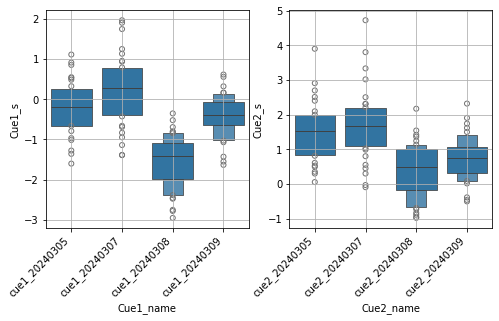

In [123]:
f, (axes) = plt.subplots(1, 2,figsize=(8,4))
sns.boxenplot(x = 'Cue1_name',y = 'Cue1_s',data = All_sync, ax = axes[0],order = ['cue1_20240305', 'cue1_20240307','cue1_20240308', 'cue1_20240309']) #,order = ['0305','0307','0308','0309']
axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=45,ha='right')#plt.set_xticklabels(rotation=45)
axes[0].grid()
sns.boxenplot(x = 'Cue2_name',y = 'Cue2_s',data = All_sync, ax = axes[1],order = ['cue2_20240305','cue2_20240307','cue2_20240308', 'cue2_20240309']) #,order = ['0305','0307','0308','0309']
axes[1].set_xticklabels(axes[1].get_xticklabels(),rotation=45,ha='right')#plt.set_xticklabels(rotation=45)
axes[1].grid()
plt.savefig('./plots/CueShifts_spread.png',bbox_inches = 'tight',dpi = 300)

plt.show()

Ignoring the difference in medians, here we see a wide range of offsets per device for every initial  synch cue, ranging over 2-3 s at the synch cue close to initialisation and 3-5 s at the second cue when it is 6-8 hrs later. 